# Speech model creation

In [31]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

In [32]:
Features = pd.read_csv("../../data/aud_em/mfcc_emo_df.csv")

In [33]:
X = Features.iloc[: ,:-1].values
Y = Features['emotion'].values

In [34]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8826, 29), (8826, 6), (2943, 29), (2943, 6))

In [36]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8826, 29), (8826, 6), (2943, 29), (2943, 6))

In [37]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((8826, 29, 1), (8826, 6), (2943, 29, 1), (2943, 6))

In [38]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [39]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(29, 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.6))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(units=6, activation='softmax'))


# Configurar el optimizador con el nuevo learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 29, 256)           1536      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 15, 256)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 15, 256)           327936    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 8, 256)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 8, 128)            163968    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 128)           

In [40]:
new_learning_rate = 0.001

In [41]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
optimizer = tf.keras.optimizers.Adam(learning_rate=new_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cp = ModelCheckpoint('saved/best_weights.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100, callbacks=[early_stopping, cp])

Epoch 1/100
276/276 [==============================] - 2s 5ms/step - loss: 1.7021 - accuracy: 0.2770 - val_loss: 1.5281 - val_accuracy: 0.3469
Epoch 2/100
276/276 [==============================] - 1s 5ms/step - loss: 1.5269 - accuracy: 0.3487 - val_loss: 1.4491 - val_accuracy: 0.3863
Epoch 3/100
276/276 [==============================] - 1s 5ms/step - loss: 1.4563 - accuracy: 0.3722 - val_loss: 1.3650 - val_accuracy: 0.4230
Epoch 4/100
276/276 [==============================] - 1s 5ms/step - loss: 1.4225 - accuracy: 0.3858 - val_loss: 1.3442 - val_accuracy: 0.4275
Epoch 5/100
276/276 [==============================] - 1s 5ms/step - loss: 1.3892 - accuracy: 0.4134 - val_loss: 1.3308 - val_accuracy: 0.4370
Epoch 6/100
276/276 [==============================] - 1s 5ms/step - loss: 1.3907 - accuracy: 0.3956 - val_loss: 1.3472 - val_accuracy: 0.4234
Epoch 7/100
276/276 [==============================] - 1s 5ms/step - loss: 1.3588 - accuracy: 0.4159 - val_loss: 1.3269 - val_accuracy: 0.4295

92/92 [==============================] - 0s 2ms/step - loss: 1.2496 - accuracy: 0.4716
Accuracy of our model on test data :  47.16275930404663 %


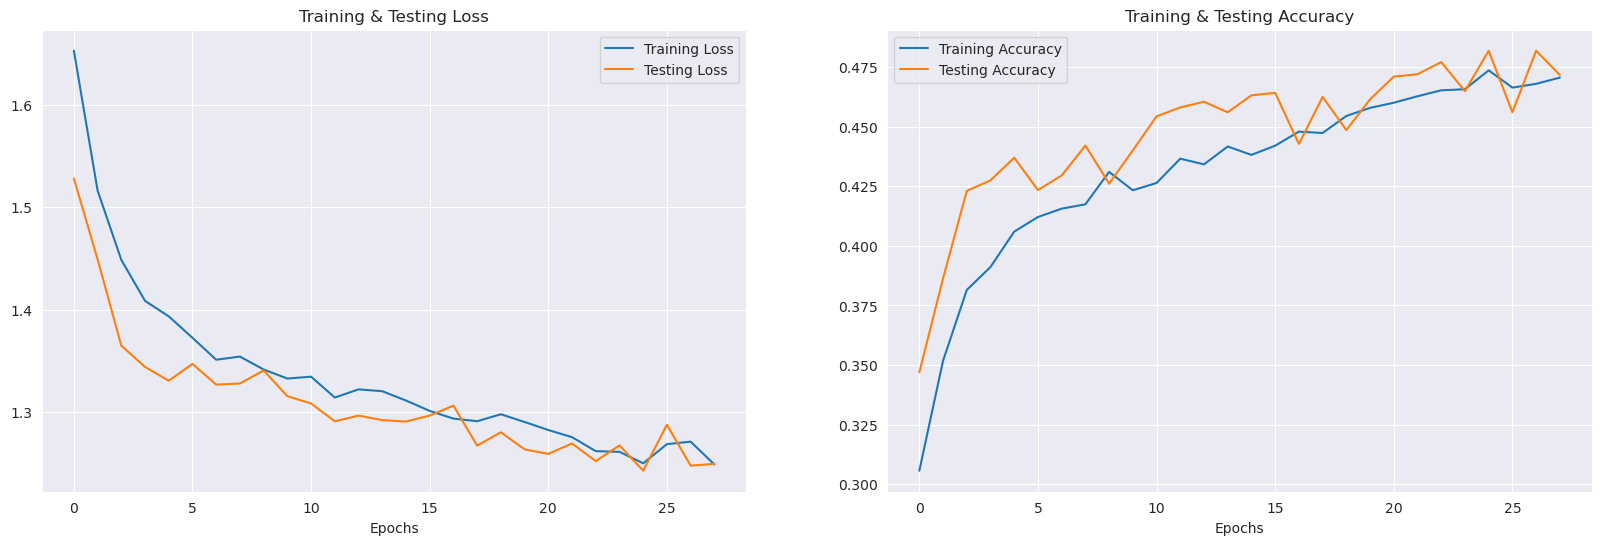

In [42]:
from matplotlib import pyplot as plt

num_epochs = len(history.epoch)

print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [43]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [44]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,anger,fear
1,anger,neutral
2,neutral,neutral
3,neutral,anger
4,sadness,sadness
5,surprise,surprise
6,neutral,neutral
7,sadness,joy
8,anger,neutral
9,anger,anger


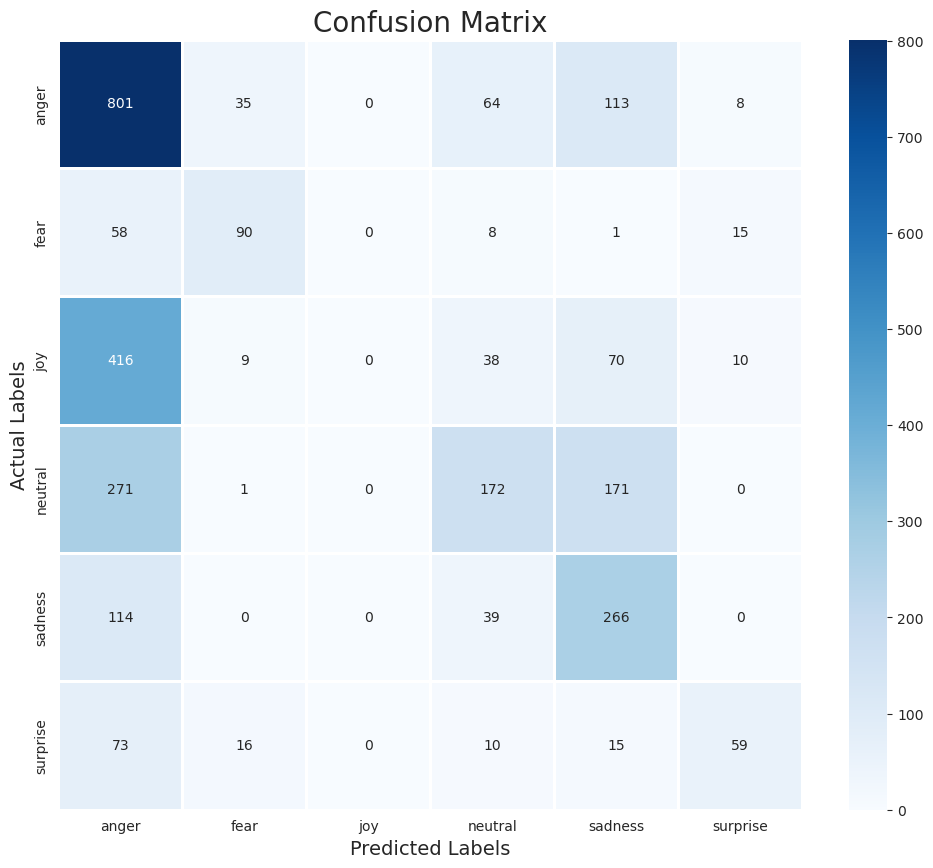

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.46      0.78      0.58      1021
        fear       0.60      0.52      0.56       172
         joy       0.00      0.00      0.00       543
     neutral       0.52      0.28      0.36       615
     sadness       0.42      0.63      0.50       419
    surprise       0.64      0.34      0.45       173

    accuracy                           0.47      2943
   macro avg       0.44      0.43      0.41      2943
weighted avg       0.40      0.47      0.41      2943



/home/jd/anaconda3/envs/tf24_conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jd/anaconda3/envs/tf24_conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jd/anaconda3/envs/tf24_conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu